In [1]:
import torch
import framework
import math
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
#%config InlineBackend.print_figure_kwargs={'facecolor' : '#00000000'}

# Generate data

In [2]:
def generate_disc_set(nb):
    # generate unif samples
    p = torch.FloatTensor(nb, 2).uniform_(0, 1)
    # assign label inside/outside circle
    center = torch.tensor([0.5,0.5]).float()
    inside = ( torch.norm(p-center, dim=1) < (1.0 / math.sqrt(2*math.pi)) )
    # Hot encoding
    label = torch.zeros(inside.shape[0], 2)
    label[inside==1,1] = 1
    label[inside==0,0] = 1
    return p, label

In [3]:
N = 1000
x_train, y_train = generate_disc_set(N)
x_test, y_test = generate_disc_set(N)

<Figure size 400x400 with 0 Axes>

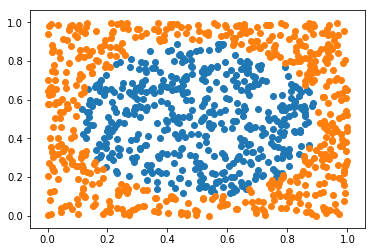

<Figure size 400x400 with 0 Axes>

In [4]:
plt.scatter(x_train[y_train[:,1] ==1][:,0], x_train[y_train[:,1] ==1][:,1])
plt.scatter(x_train[y_train[:,0] ==1][:,0], x_train[y_train[:,0] ==1][:,1])
plt.figure(figsize=(5,5), dpi=80)

# Build Model

In [5]:
H = 25 # hidden layer size
hidden_nb = 3 # hidden layer amount
modules_array = []

# Input layer
modules_array.append(framework.Linear(2, H, 'relu'))
# Hidden layers
for i in range(0, hidden_nb):
    modules_array.append(framework.ReLU())
    modules_array.append(framework.Linear(H, H, 'relu'))
# Output layer
modules_array.append(framework.ReLU())
modules_array.append(framework.Linear(H, 2, 'none'))

model = framework.Sequential(modules_array)

# Train and evaluate

In [6]:
def compute_error_percent(prediction, target) :
    errors = (prediction.argmax(dim=1) != target.argmax(dim=1))
    return (100 * errors.sum() / target.shape[0]).item()

In [7]:
def compute_test_error(model, test_input, test_target) :
    # Forward pass
    output = model.forward(test_input)
    # Compute error %
    return compute_error_percent(output, test_target)

In [8]:
def train(model, x_train, y_train) :
    mini_batch_size = 200
    epochs = 500
    lr = 1e-2
    train_loss_hist = []
    train_error_hist = []
    test_error_hist = []
    optimizer = framework.SGD(model.param(), lr)
    for e in range(0, epochs):
        # variables to accumulate loss and error over the batches of this epoch
        train_loss_buffer = 0
        train_error_buffer = 0
        for b in range(0, x_train.size(0), mini_batch_size):
                # Forward pass of neural net
                x_batch = x_train.narrow(0, b, mini_batch_size)
                y_batch = y_train.narrow(0, b, mini_batch_size)
                output = model.forward(x_batch)
                # Compute loss
                loss_module = framework.LossMSE(y_batch)
                loss = loss_module.forward(output)
                train_loss_buffer += loss.item()
                # Compute train error
                train_error_buffer += compute_error_percent(output,y_batch)
                # Set all gradients to zero
                optimizer.zero_grad()
                # Backward
                model.backward(loss_module.backward())
                # Step
                optimizer.step()
        # Store average loss & error for this epoch
        batch_per_epoch = x_train.size(0) / mini_batch_size
        train_loss_hist.append(train_loss_buffer / batch_per_epoch)
        train_error_hist.append(train_error_buffer / batch_per_epoch)
        # Compute a test error
        test_error_hist.append(compute_test_error(model, x_test, y_test))
    return train_loss_hist, train_error_hist, test_error_hist

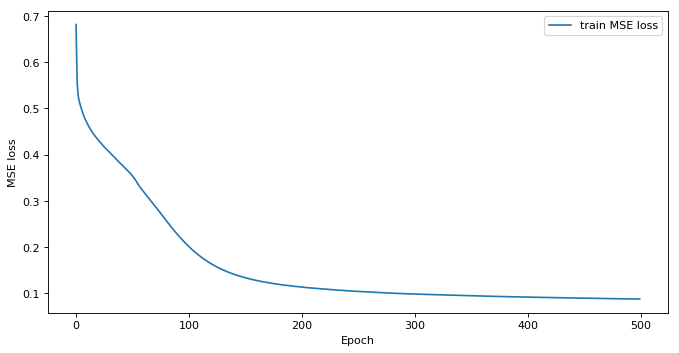

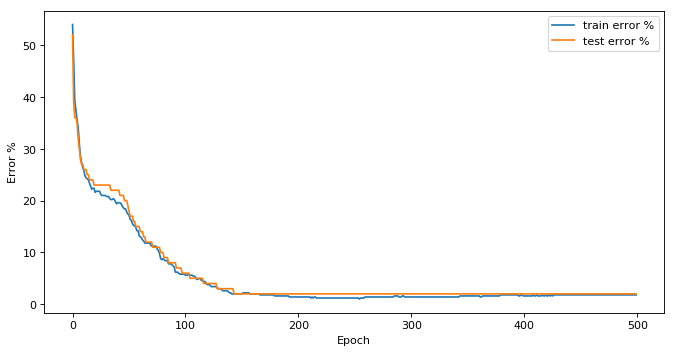

In [9]:
train_loss_hist, train_error_hist, test_error_hist = train(model, x_train, y_train)

plt.figure(figsize=(10,5), dpi=80)
plt.plot(train_loss_hist,label='train MSE loss')
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5), dpi=80)
plt.plot(train_error_hist,label='train error %')
plt.plot(test_error_hist, label='test error %')
plt.ylabel('Error %')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Vizualise learned model

<Figure size 400x400 with 0 Axes>

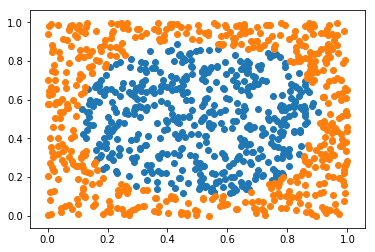

<Figure size 400x400 with 0 Axes>

In [10]:
output = model.forward(x_train)
output = output.argmax(dim=1)

label = torch.zeros(output.shape[0], 2)
label[output==1,1] = 1
label[output==0,0] = 1

plt.scatter(x_train[label[:,1] ==1][:,0], x_train[label[:,1] ==1][:,1])
plt.scatter(x_train[label[:,0] ==1][:,0], x_train[label[:,0] ==1][:,1])
plt.figure(figsize=(5,5), dpi=80)

In [11]:
# TODO implement tanh. How should we use it ? put it on last layer so that we are always in -1,1 ?
# and then bias and weights will learn to put it back in 0,1 ?